In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

#импорт библиотек по подбору гиперпаратемтов
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

#Зафиксируем сразу randomstate
RandomState = 42


C:\Users\killr\AppData\Local\Temp\ipykernel_11956\4230976023.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = pd.read_csv('_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Т.к. данные предобработаны, перейдем сразу к выполнению задания. Структура будет следующая: сначала построим логистическую регрессию и на ней подберем гиперпараметры всеми методами. А потом перейдем к случайному лесу.

Однако, проверим сначала выборку на сбалансированность:

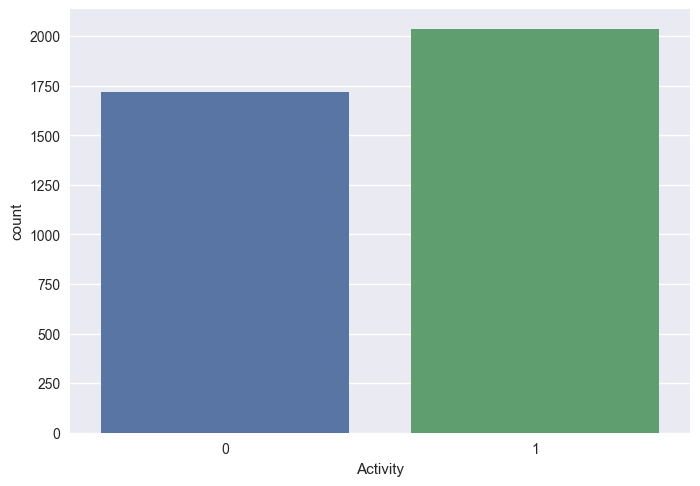

In [3]:
sns.countplot(data=data, x='Activity');

Будем считать, что классы сбалансированы

Признаков много, тут хорошо бы мультиколлериарность посмотреть. Но буду доверять предобработке.
Разобъем выборку

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RandomState, test_size = 0.2)

# Логистическая регрессия

### Строим модель по умолчанию и смотрим целевую метрику

In [5]:
log_reg = linear_model.LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


### Подберем гиперпараметры с помощью **GridSearchCV**

In [6]:
#Зададим сетку параметров. Делаю по аналогии с теоретическим блоком модуля. Потом посмотрим стоит ли еще сто-то попробовать
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

In [8]:
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RandomState, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, #зададим число фолдов (автоматически производим кросс-валидацию)
    n_jobs = -1 #используем все ядра 
)  
%time grid_search_1.fit(X_train, y_train) 

y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 2.88 s
Wall time: 18min 32s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


Считали-считали и насчитали на тот же результат, что и по умолчанию. Можно попробовать какие-то значения вокруг c = 0.1, но продолжим другим, юолее быстрым способом

### Подберем гиперпараметры с помощью **RandomizedSearchCV**

In [9]:
param_distributions = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

In [10]:

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RandomState, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 312 ms
Wall time: 3min 8s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5}


Метрику улучшили. Параметры вообще другие получили, чем в "переборе" с помощью GridSearch. Что, в общем-то логично. Результат идентичен теоретической части модуля, а за счет рандомизации мы попали в лучшие параметры. И быстрее.

### Подберем гиперпараметры с помощью **Hyperopt**

In [20]:
# зададим пространство поиска гиперпараметров. Я буду ориентироваться на второй блок гиперпараметров в исходной сетке, т.к. он показал улучшение метрики в прошлом подходе
space={'C': hp.quniform('C', 0.1, 1, 0.1)}

In [22]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RandomState):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'C': params['C']}
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, solver='liblinear', penalty='l1', random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [23]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RandomState)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [00:10<00:00,  1.85trial/s, best loss: -0.8698334361505243]
Наилучшие значения гиперпараметров {'C': 0.9}


In [24]:
# рассчитаем точность для тестовой выборки
model =  linear_model.LogisticRegression(
    random_state=RandomState, 
    C=best['C'],
    solver='liblinear', 
    penalty='l1')

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.87
f1_score на тестовом наборе: 0.78


Лучше сработал RandomizedSearch. Хотя я оставил только один параметр на подбор. Я думаю это от этого зависело.

### Подберем гиперпараметры с помощью **Optuna**

In [27]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  C = trial.suggest_float('C',0.01,1,step=0.05,log=False) 
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  # создаем модель
  model = linear_model.LogisticRegression(C=C,
                                          solver=solver,
                                          penalty=penalty,
                                          random_state=RandomState)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [29]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogReg", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-03-21 17:07:26,031] A new study created in memory with name: LogReg
c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:701: UserWarning: The distribution is specified by [0.01, 1] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 0.96].
  warnings.warn(
[I 2023-03-21 17:07:26,844] Trial 0 finished with value: 0.8756923076923077 and parameters: {'C': 0.51, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 0 with value: 0.8756923076923077.
c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:701: UserWarning: The distribution is specified by [0.01, 1] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 0.96].
  warnings.warn(
[I 2023-03-21 17:07:27,669] Trial 1 finished with value: 0.8849120641777228 and parameters: {'C': 0.91, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.8849120641777228.
c:

CPU times: total: 29.7 s
Wall time: 34.4 s


In [30]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'C': 0.96, 'solver': 'liblinear', 'penalty': 'l2'}
f1_score на обучающем наборе: 0.89


In [31]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, random_state=RandomState)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


Тоже не побили рекорд по итоговой метрике, но можно и дальше подбирать

# Случайный лес

### Строим модель по умолчанию и смотрим целевую метрику

In [32]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=RandomState)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.83


Видим, что эта модель лучше справляется с задачей даже без подбора гиперпараметров

### Подберем гиперпараметры с помощью **GridSearchCV**

In [33]:
param_grid =  {'n_estimators': list(range(80, 200, 40)),
              'min_samples_leaf': [4,5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }

In [34]:
grid_search_1 = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RandomState), 
    param_grid=param_grid, 
    cv=3, #зададим число фолдов (автоматически производим кросс-валидацию). Поставил поменьше т.к. задание обучающее, чтобы быстрее считалось
    n_jobs = -1 #используем все ядра 
)  
%time grid_search_1.fit(X_train, y_train) 

y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 12.3 s
Wall time: 4min 59s
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'max_depth': 22, 'min_samples_leaf': 4, 'n_estimators': 120}


Вот, подобрали, метрика итоговая улучшилась

Можно конечно дальше подбирать вручную, однако воспользуемся более продвинутыми методами

### Подберем гиперпараметры с помощью **RandomizedSearchCV**

In [36]:
param_distributions =  {'n_estimators': list(range(80, 200, 40)),
              'min_samples_leaf': [4,5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }

In [37]:
random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RandomState), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 8.38 s
Wall time: 3min 32s
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 4, 'max_depth': 40}


Параметры получились другие. Но по метрике результат идентичный

### Подберем гиперпараметры с помощью **Hyperopt**

In [38]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [39]:
# зафксируем random_state
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RandomState):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [41]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RandomState)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [04:55<00:00, 14.80s/trial, best loss: -0.9860031104199067]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}


In [42]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=RandomState, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.84


Отлично, еще получилось улучшить

In [43]:
print("Наилучшие значения гиперпараметров {}".format(best))

Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}


Вот какие получились гиперпараметры

### Подберем гиперпараметры с помощью **Optuna**

In [46]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=RandomState)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [47]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2023-03-21 17:57:49,278] A new study created in memory with name: RandomForestClassifier
[I 2023-03-21 17:58:06,829] Trial 0 finished with value: 0.9906658369632856 and parameters: {'n_estimators': 157, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9906658369632856.
[I 2023-03-21 17:58:16,953] Trial 1 finished with value: 0.9067743940335612 and parameters: {'n_estimators': 100, 'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9906658369632856.
[I 2023-03-21 17:58:27,842] Trial 2 finished with value: 0.9629167965098162 and parameters: {'n_estimators': 103, 'max_depth': 15, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9906658369632856.
[I 2023-03-21 17:58:39,663] Trial 3 finished with value: 0.9304347826086956 and parameters: {'n_estimators': 115, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9906658369632856.
[I 2023-03-21 17:58:58,898] Trial 4 finished with value: 0.9527950310559007 and parameters: {'n_

CPU times: total: 7min 38s
Wall time: 8min 11s


In [49]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=RandomState )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.83


In [50]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 163, 'max_depth': 30, 'min_samples_leaf': 2}


И вывели олучшие значения параметров